# Предсказание вида упаковочного материала по характеристикам товара

Для того, чтобы покупатель получил заказ, перед отправкой заказанные товары упаковывают в посылки. Компания заметила, что сотрудник тратит большое количество времени на выбор упаковочного материала, в который необходимо упаковать товары. Существует большое количество упаковочного материала (коробки, пакеты, пленка). Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала.  

Цель нашего проекта - с высокой точностью рекомендовать правильную упаковку для заказа, которая позволит доставить товары без порчи клиенту и минимизирует затраты на упаковочный материал.  

Исследование пройдет в пять этапов:
1. Обзор данных
2. Анализ и предобработка данных
3. Подготовка датасета
4. Разработка алгоритма предсказания упаковки
5. Выводы


## Содержание
* [1. Обзор данных](#overview)
 - [1.1. data](#data)
 - [1.2. sku](#sku)
 - [1.3. sku_cargotypes](#sku_cargotypes)
 - [1.4. cargotype_info](#cargotype_info)
 - [1.5. carton](#carton)
 - [1.6. carton_price](#carton_price)
* [2. Анализ и предобработка данных](#analysis)
 - [2.1. Существующая модель](#old_model)
 - [2.2. Количество товаров в заказе](#items)
 - [2.3. Упаковка](#pack)
* [3. Подготовка датасета](#dataset)
 - [3.1. Датасет для заказов с 1 товаром](#dataset_1)
 - [3.2. Датасет для заказов с 2-5 товарами](#dataset_2-5)
* [4. Алгоритмы](#algorithms)
 - [4.1. Алгоритм для заказов из одного товара](#one_item)
   - [4.1.1. Подсчет экономии и % верных предсказаний](#one_item_savings)
 - [4.2 ML-подход для заказов из 2-5 товаров](#2-5)
   - [4.2.1. Подсчет экономии и финальная точность алгоритма](#2-5_item_savings)
 * [5. Выводы](#conclusion)

## 1. Обзор данных <a class="anchor" id="overview"></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import pickle
import json

from tqdm import tqdm
import warnings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)
tqdm.pandas()

SEED = 42
PTH = './datasets/'

Считаем датасеты и сохраним их в переменные:

In [3]:
data = pd.read_csv(PTH + 'data.csv', index_col=0)
cargotype_info = pd.read_csv(PTH + 'cargotype_info.csv', index_col=0)
carton = pd.read_csv(PTH + 'carton.csv')
sku = pd.read_csv(PTH + 'sku.csv', index_col=0)
sku_cargotypes = pd.read_csv(PTH + 'sku_cargotypes.csv', index_col=0)
carton_price = pd.read_excel(PTH + 'carton_price.xlsx')

Функция для просмотра датасета

In [4]:
def total_view(df, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return pd.concat([df.head(n_rows),
                      df.sample(n_rows,random_state=seed),
                      df.tail(n_rows)
                     ])

#### 1.1. data <a class="anchor" id="data"></a>

In [5]:
display(total_view(data), data.describe().T)
data.info()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
72528,0,777e3d390df54edcb8093dcc56aef7a1,YMF,1,YMF,YMF,13125,YMF,624,13125,0.100,86693a641c46e12e7287d3c6e3acc6b2,b217f95328ef08f9daad2d24876ad827,70751d08b7f2227555534189fbbfae3f
212753,1,c2d0ad21d90a981cdbb9f592b3327587,YML,1,YML,YML,104586,YML,2975,104586,0.090,4557dfce2a53e74186156d84b44d0c9c,0c9840143a5e05b6aa7106cb8abe4e25,54a4fa8c3c7174960c9ea7a9c8681450
57520,0,ef6cf797472783cdb27f0ab94b94fb3a,YMG,1,YMG,YMG,26820,YMG,2760,26820,0.300,1646494695c16dddd4d24b40927c93b9,b40ffb303d0a5657a71bd6820b2379c0,d58b6027a7e1f518e54e6a5ab982e094
208815,1,f93f25359c27be22baaf753a550d3776,MYB,1,YMA,MYB,3449,YMA,1100,4068,0.320,cf6f51c457600a9d633bf4863cfa9b72,11585eb785f4d642f6efaa5e6c416514,5ada381ddc53755d738daad478a0d831
107402,0,c6f08cf222f425f397a9f1beaac0e485,NONPACK,197,YML,NONPACK,0,YML,18480,108000,0.501,dabdf863febc1a50b1e3c010cc3c5082,78e1fda96541f53010032b9e9b450727,5b2f115665816b42ad48b6e3207353cc


,count,mean,std,min,25%,50%,75%,max
whs,325623.0,1.366166,2.098641,0.0,0.00,0.0,3.000,7.0
box_num,325623.0,2.787773,15.774209,1.0,1.00,1.0,1.000,235.0
sel_calc_cube,325623.0,11188.402656,13958.516542,0.0,3449.00,8436.0,15579.000,108000.0
pack_volume,325623.0,5440.789656,28581.901292,0.0,500.00,1192.0,3154.000,1815450.0
rec_calc_cube,325623.0,18253.646168,26745.365119,0.0,3449.00,8525.0,18270.000,108000.0
goods_wght,325623.0,1.134705,4.090043,0.0,0.11,0.3,0.799,153.7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid              325623 non-null  object 
dtypes: float64(1), int64

В таблице data $14$ колонок и $325$ $623$ строк. Тип данных в колонках `float64`, `int64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `whs` - код сортировочного центра;
- `orderkey` - id заказа;
- `selected_cartontype` - код упаковки, которая была выбрана пользователем;
- `box_num` - номер коробоки в заказе;
- `recommended_cartontype` - код упаковки, рекомендованной алгоритмом;
- `selected_carton` - код упаковки, которая была выбрана пользователем (дубль);
- `sel_calc_cube` - объём выбранной упаковки;
- `recommended_carton` - код упаковки, рекомендованной алгоритмом (дубль);
- `pack_volume` - рассчитанный объём упакованных товаров;
- `rec_calc_cube` - объем рекомендованной упаковки;
- `goods_wght` - вес товара;
- `sku` - id товара;
- `who` - упаковщик;
- `trackingid` - id доставки.

Убедимся, что в колонках `selected_carton` и `recommended_carton` действительно находятся дубли и удалим их:

In [6]:
print(f"Количество расхождений с selected_carton: {(data['selected_cartontype'] != data['selected_carton']).sum()}",
      f"Количество расхождений с recommended_carton: {(data['recommended_cartontype'] != data['recommended_carton']).sum()}",
      sep='\n')

Количество расхождений с selected_carton: 0
Количество расхождений с recommended_carton: 0


In [7]:
data = data.drop(['selected_carton', 'recommended_carton'], axis=1)
data.duplicated().sum()

91795

- в каждой строке содержится информация об одном товаре (id заказа, id товара, его вес, код и объем выбранной упаковки, количество коробок и тд.);
- пропущенные значения отсутствуют;
- в таблице $91$ $795$ дубликатов, потому что одновременно можно заказать несколько позиций одного товара.

### 1.2. sku <a class="anchor" id="sku"></a>

In [8]:
display(total_view(sku), sku.describe().T)
sku.info()

,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0
4573744,9f53afb417a99f4ab19b3c9c8067c6e1,10.0,3.0,11.0
4167376,8223d1328a032db925bcd145e7200a1b,7.0,16.0,5.0
273510,729cdfc03a12b4deae370ae60e591f98,4.0,11.0,44.0
1025186,ed91347c30fc8e5ad1ef69aa4e2040e9,12.0,12.0,6.0
1817268,8f80f0d103b59164ff5f30a93dfad2cc,22.0,2.0,14.0


,count,mean,std,min,25%,50%,75%,max
a,6385961.0,21.084677,18.906759,0.0,10.0,18.0,28.0,6554.0
b,6385961.0,12.033526,14.877446,0.0,3.0,8.0,16.0,2050.0
c,6385961.0,17.825241,15.088379,0.0,8.0,15.0,24.0,593.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6385961 entries, 0 to 6385960
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sku     object 
 1   a       float64
 2   b       float64
 3   c       float64
dtypes: float64(3), object(1)
memory usage: 243.6+ MB


В таблице `sku` $4$ колонки и $6$ $385$ $961$ строка. Тип данных в колонках `float64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `sku` - id товара;
- `a`, `b`, `c`, - размеры.

Посчитаем для скольких объектов полностью отсутствует информация о габаритах:

In [9]:
print(f"Отсутствуют все данные: {sku[(sku['a'] == 0) & (sku['b'] == 0) & (sku['c'] == 0)].shape[0]}")
measurements = []
for i in tqdm(range(len(sku))):
    cnt = 0
    for col in ['a', 'b', 'c']:
        if sku.loc[i, col] == 0:
            cnt += 1
    measurements.append(cnt)
np.unique(measurements)

Отсутствуют все данные: 271123


100%|██████████| 6385961/6385961 [02:04<00:00, 51349.71it/s]


array([0, 3])

Полностью отсутствуют данные о габаритах $271$ $123$ товаров. По остальным товарам информация имеется в полном объеме.

In [10]:
len(sku['sku'].unique()) == sku.shape[0]

True

Все id товаров в таблице уникальные.

### 1.3. sku_cargotypes <a class="anchor" id="sku_cargotypes"></a>

In [11]:
display(total_view(sku_cargotypes), sku_cargotypes.describe().T)
sku_cargotypes.info()

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290
6877319,5dcec2dbc993fc4b6804293acf61b4bc,950
3758046,37308d1512370cd7fc1f9c79a9371b71,290
11917063,fe21140f2188e7664467ced89aabd144,960
7530394,8e5c5befb9213d1eb51ee116486f7865,292
18929837,82ca45d17443c81dceb8c3c3cef19b9f,290


,count,mean,std,min,25%,50%,75%,max
cargotype,21053152.0,526.383857,259.078457,0.0,290.0,441.0,691.0,1300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053152 entries, 0 to 21053151
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sku        object
 1   cargotype  int64 
dtypes: int64(1), object(1)
memory usage: 481.9+ MB


В таблице `sku_cargotypes` $2$ колонки и $21$ $053$ $152$ строки. Тип данных в колонках `int64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `sku` - id товара;
- `cargotype`, - карготип товара.

Пропущенные значения отсутствуют. 

In [12]:
sku_cargotypes.duplicated().sum()

0

Дубликаты отсутствуют.

### 1.4. cargotype_info <a class="anchor" id="cargotype_info"></a>

In [13]:
display(total_view(cargotype_info), cargotype_info.describe().T)
cargotype_info.info()

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует вывода через ЦРПТ маркированных товаров"
4,990.0,Потребует обязательной маркировки в ближайшем будущем
14,720.0,готовое блюда
55,315.0,керамика/стекло/камень/фарфор
59,305.0,мебель
24,230.0,техника и электроника с литий-ионными батареями
67,NaN,2023-04-11


,count,mean,std,min,25%,50%,75%,max
cargotype,96.0,547.697917,305.272617,0.0,302.75,600.5,772.5,1300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  98 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


В таблице `cargotype_info` $2$ колонки и $98$ строк. Тип данных в колонках `float64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `cargotype`, - карготип товара;
- `description` - описание карготипа.

В колонке `cargotype` пропущено $2$ значения. В описании к этим пропускам стоит дата '2023-04-11'. Удалим строки с пропусками:

In [14]:
cargotype_info = cargotype_info.dropna(axis=0)
cargotype_info.duplicated().sum()

0

Дубликаты отсутствуют.

### 1.5. carton <a class="anchor" id="carton"></a>

In [15]:
display(total_view(carton), carton.describe().T)
carton.info()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,30.0,30.0,44.50,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
16,STRETCH,0.0,0.0,0.00,1
25,MYB,22.0,32.0,4.90,1
26,MYC,30.0,38.0,7.40,1
3,YMF,35.0,25.0,15.00,1
28,MYE,43.0,63.0,9.70,1


,count,mean,std,min,25%,50%,75%,max
LENGTH,29.0,39.824138,22.712122,0.0,27.0,40.0,52.0,89.5
WIDTH,29.0,30.362069,18.273173,0.0,20.0,29.0,40.0,63.0
HEIGHT,29.0,27.466552,26.453974,0.0,5.0,15.0,45.0,86.0
DISPLAYRFPACK,29.0,0.620690,0.493804,0.0,0.0,1.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CARTONTYPE     29 non-null     object 
 1   LENGTH         29 non-null     float64
 2   WIDTH          29 non-null     float64
 3   HEIGHT         29 non-null     float64
 4   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ KB


В таблице `carton` $5$ колонок и $29$ строк. Тип данных в колонках `float64`, `int64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `CARTONTYPE` - идентификатор (код) упаковки;
- `LENGTH`, `WIDTH`, `HEIGTH` - линейные размеры упаковки;
- `DISPLAYFRACK` - коробка есть на складе (не учитываем для наших целей).

Упаковка с идентификаторами KSD, STRETCH и отсутсвие упаковки NONPACK не содержат информацию о габаритах. Все остальные виды упаковки содержат информацию в полном объеме. Пропущенные значения отсутствуют.

In [16]:
carton.duplicated().sum()

0

Дубликаты отсутствуют.

### 1.6. carton_price <a class="anchor" id="carton_price"></a>

In [17]:
display(carton_price, carton_price.describe().T)
carton_price.info()

,Unnamed: 0,01.03.2023
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722
5,MYF,4.083130
6,YMA,4.392937
7,YMC,7.777487
8,YME,23.670260
9,YMF,10.661487


,count,mean,std,min,25%,50%,75%,max
01.03.2023,15.0,14.067584,12.921889,1.109861,4.238034,8.062722,20.568314,40.911178


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15 non-null     object 
 1   01.03.2023  15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes


В таблице `carton_price` $2$ колоноки и $15$ строк. Тип данных в колонках `float64` и `object` - соответствует содержащимся в них типам данных. Согласно документации, в нашем распоряжении следующая информация:
- `Unnamed: 0` - идентификатор (код) упаковки;
- `01.03.2023` - стоимость упаковки на дату $01.03.2023$.

Пропущенные значения отсутствуют.

In [18]:
carton_price.duplicated().sum()

0

Дубликаты отсутствуют.

**Выводы:**
- в нашем распоряжении историческая информация о заказанных товарах и упаковке, представленая в $6$ таблицах;
- в таблице `data` $91$ $795$ дубликатов, потому что одновременно можно заказать несколько позиций одного товара;
- в таблице `sku` полностью отсутствуют данные о габаритах $271$ $123$ товаров. По остальным товарам информация имеется в полном объеме;
- в таблице `carton` упаковка с идентификаторами KSD, STRETCH и отсутсвие упаковки NONPACK не содержат информацию о габаритах. Все остальные виды упаковки содержат информацию в полном объеме;
- в таблице `carton_price` содержится информация о ценах на $15$ различных видов упаковки на дату $01.03.2023$.

**Что сделано:**
- удалены колонки `selected_carton` и `recommended_carton` таблицы `data`, содержавшие дубли;
- удалены строки с пропущенными значениями в таблице `cargotype_info`.

## 2. Анализ и предобработка данных <a class="anchor" id="analysis"></a>

### 2.1. Существующая модель <a class="anchor" id="old_model"></a>

Посчитаем как часто упаковщик выбирал рекомендованную моделью упаковку:

In [19]:
# accuracy по заказам
pivot_data = data.groupby(by=['orderkey',
                              'selected_cartontype',
                              'recommended_cartontype']) \
                 .agg({'who': 'count'}) \
                 .reset_index()
pivot_data['acc'] = pivot_data['selected_cartontype'] == pivot_data['recommended_cartontype']
print('Доля совпавших упаковок по заказам',
      1 - (len(pivot_data.loc[pivot_data['acc']== False, 'orderkey'].unique()) / len(data['orderkey'].unique())))

# accuracy по sku
pivot_data = data.groupby(by=['selected_cartontype',
                              'recommended_cartontype',
                              'sku']) \
                 .agg({'who': 'count'}) \
                 .reset_index()
pivot_data['acc'] = pivot_data['selected_cartontype'] == pivot_data['recommended_cartontype']
print('Доля совпавших упаковок по sku', pivot_data['acc'].mean())

# accuracy по каждому товару
print('Доля совпавших упаковок по каждому товару',
      1 - (data['selected_cartontype'] != data['recommended_cartontype']).mean())

Доля совпавших упаковок по заказам 0.26463580134960196
Доля совпавших упаковок по sku 0.2421386712801082
Доля совпавших упаковок по каждому товару 0.2541835189774678


Выбранная пользователем и предложенная текущей моделью упаковка совпадает примерно в $25$ % случаев. В остальных случаях упаковщик делает другой выбор. Это обусловлено некоторыми требованиями к упаковке нескольких товаров (например, если нельзя упаковывать бытовую химию вместе с продуктами) и ошибкой модели - иногда можно выбрать более оптимальную и дешевую упаковку, чем предложенная моделью.

### 2.2. Количество товаров в заказе <a class="anchor" id="items"></a>

Посмотрим на основные закономерности количества товаров в заказе:

In [20]:
items_in_orders = data.groupby(['orderkey'])['selected_cartontype'] \
                      .count() \
                      .reset_index() \
                      .rename(columns={'selected_cartontype': 'items_total'})

print(f'Количество заказов всего: {items_in_orders.shape[0]}')
data = data.merge(items_in_orders, on='orderkey', how='left')

Количество заказов всего: 159899


Посчитаем количество заказов в разрезе количества заказанных товаров:

In [21]:
def categories(df, column_name, number, category_name):
   """
   Объединяет значения из df[column_name], встречающиеся реже количества number
   в выбранную категорию category_name
   """
   values = df[column_name].value_counts(dropna=False)
   idx_list = values[values < number].index
   df.loc[df[column_name].isin(idx_list), column_name] = category_name
   return df[column_name].value_counts(dropna=False)

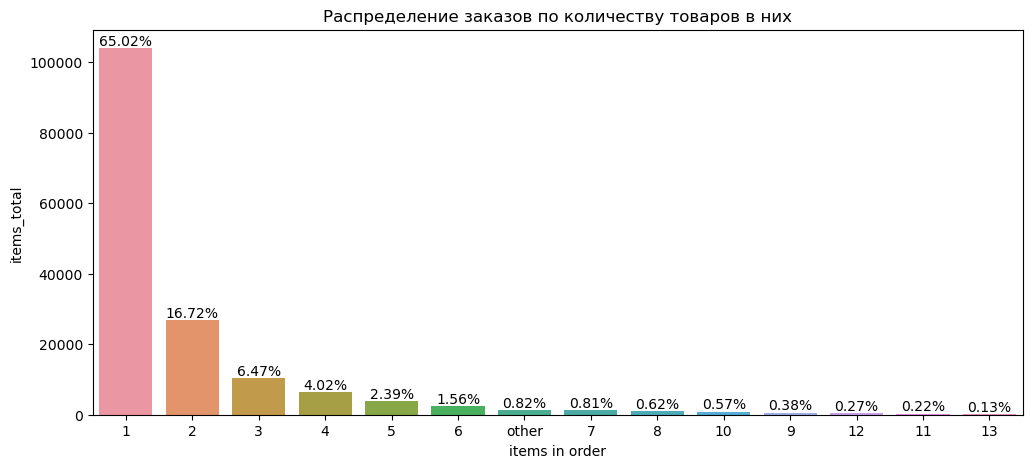

In [22]:
tmp = categories(items_in_orders, 'items_total', 200, 'other').reset_index()
tmp['share'] = round(tmp['items_total'] / items_in_orders.shape[0] * 100, 2)

plt.figure(figsize=(12, 5))
ax = sns.barplot(data=tmp, y='items_total', x='index')
values = [str(x) + '%' for x in tmp['share']]
values_orders_total = tmp['share'].cumsum()
for i in ax.containers:
    ax.bar_label(i, values)
plt.title('Распределение заказов по количеству товаров в них')
plt.xlabel('items in order')
None

In [23]:
round(tmp.loc[:6, 'share'].sum(), 2)

97.0

$65$ % заказов состоят из одного товара, $97$ % заказов включает не более $5$ товаров.

In [24]:
data.groupby(['orderkey', 'whs'])['selected_cartontype'].count().shape[0] == items_in_orders.shape[0]

True

Для каждого заказа есть только один код сортировочного центра. Значит каждый заказ в нашем датасете был собран на одном складе.

In [25]:
tmp = data.groupby(['orderkey', 'whs', 'who'])['selected_cartontype'] \
          .count() \
          .reset_index() \
          .rename(columns={'selected_cartontype': 'amount'})
print(tmp.shape[0])

160226


Здесь мы получили большее количество строк ($160$ $226$), чем заказов в датасете ($159$ $899$), значит некоторые заказы собирались несколькими сборщиками. Посмотрим на них подробнее:

In [26]:
tmp = tmp.groupby('orderkey')['who'].count()
tmp.value_counts()


1    159609
2       261
3        24
5         3
4         2
Name: who, dtype: int64

Практически каждый заказ собирается одним сборщиком. Бывают случаи, когда заказ собирают от $2$ до $5$ сборщиков, но они составляют менее $0.2$ %.

In [27]:
# посчитаем количество заказов с 2 и более упаковками
tmp = data.groupby(['orderkey', 'box_num'])['selected_cartontype'].count().reset_index()
tmp = tmp.groupby(['orderkey'])['box_num'].count().reset_index().rename(columns={'box_num': 'box_sum'})
print(f'Количество заказов с 2 и более упаковками среди всех заказов: {tmp[tmp["box_sum"] > 1].shape[0]} шт',
      f'Доля заказов с 2 и более упаковками среди всех заказов: {round(tmp[tmp["box_sum"] > 1].shape[0] / items_in_orders.shape[0] * 100, 2)} %',
      sep='\n')

Количество заказов с 2 и более упаковками среди всех заказов: 6544 шт
Доля заказов с 2 и более упаковками среди всех заказов: 4.09 %


In [28]:
# возьмем срез товаров из data, для которых selected_cartontype был не STRETCH и NONPACK
# посчитаем по оставшимся товарам количество заказов с 2 и более упаковками
tmp = data[~((data['selected_cartontype'] == 'NONPACK') | (data['selected_cartontype'] == 'STRETCH'))] \
      .groupby(['orderkey', 'box_num'])['selected_cartontype'] \
      .count() \
      .reset_index()
tmp = tmp.groupby(['orderkey'])['box_num'].count().reset_index().rename(columns={'box_num': 'box_sum'})

print(f'Количество заказов с 2 и более упаковками: {tmp[tmp["box_sum"] > 1].shape[0]} шт',
      f'Доля заказов с 2 и более упаковками: {round(tmp[tmp["box_sum"] > 1].shape[0] / items_in_orders.shape[0] * 100, 2)} %',
      sep='\n')

Количество заказов с 2 и более упаковками: 2028 шт
Доля заказов с 2 и более упаковками: 1.27 %


Только $4,09$ % всех заказов не помещается в одну упаковку. При этом без учета товаров, для которых упаковщики выбирали `STRETCH` или `NONPACK`, этот процент снижается до $1.27$ %.

Отберем стороки в датасете без NONPACK и STRETCH и посчитаем количество заказов, поместившихся в одну коробку в зависимости от количества товаров. Выведем долю заказов, поместившихся в одну упаковку накопительным итогом:

In [29]:
tmp = (data[~((data['selected_cartontype'] == 'NONPACK') | (data['selected_cartontype'] == 'STRETCH'))]
        # группируем данные в заказах по упаковкам
        .groupby(['orderkey', 'items_total', 'box_num'])['selected_cartontype']
        .count()
        .reset_index()
        # группируем данные по заказам и считаем количество упаковок на каждый заказ
        .groupby(['orderkey', 'items_total'])['box_num']
        .count()
        .reset_index()
        # группируем данные по количеству товаров в заказе и считаем сколько из них поместилось в 1 упаковку, в 2, 3 и тд.
        .groupby(['items_total', 'box_num'])['orderkey']
        .count()
        .reset_index()
        .rename(columns={'orderkey': 'orders_total'})
        )

# считаем сумму заказов для каждого количества товаров в заказе
orders_all = tmp.groupby('items_total')['orders_total'] \
                .sum() \
                .reset_index() \
                .rename(columns={'orders_total': 'orders_all'})

# добавляем к таблице tmp сумму заказов для каждого количества товаров в заказе
tmp = tmp.merge(orders_all, on='items_total', how='left')

# оставляем только данные о заказах, которые поместились в одну упаковку
tmp = tmp[tmp['box_num'] == 1].reset_index(drop=True)

# добавим категории по количеству товаров в заказе, объединим редкие по кличеству заказов категории в группу other
tmp['items_in_order'] = [x if tmp.loc[i, 'orders_total'] > 200 else 'other' for i, x in enumerate(tmp['items_total'])]

# сгруппируем данные по выделенным категориям - заказы группы other суммируются, посчитаем накопительные суммы
# количества заказов и добавим долю заказов, поместившихся в одну упаковку по категориям накопительным итогом
# по порядку, начиная от 1 товара в заказе
tmp = tmp.groupby('items_in_order')['orders_total', 'orders_all'].sum().reset_index()
tmp['cumsum_one_pack'] = tmp['orders_total'].cumsum()
tmp['cumsum_one_pack_all'] = tmp['orders_all'].cumsum()
tmp['share'] = round(tmp['cumsum_one_pack'] / tmp['cumsum_one_pack_all'] * 100, 2)
tmp


,items_in_order,orders_total,orders_all,cumsum_one_pack,cumsum_one_pack_all,share
0,1,82699,82699,82699,82699,100.00
1,2,23619,24063,106318,106762,99.58
2,3,9363,9656,115681,116418,99.37
3,4,5838,6051,121519,122469,99.22
4,5,3500,3654,125019,126123,99.12
5,6,2271,2393,127290,128516,99.05
6,7,1163,1255,128453,129771,98.98
7,8,868,961,129321,130732,98.92
8,9,520,582,129841,131314,98.88
9,10,812,884,130653,132198,98.83


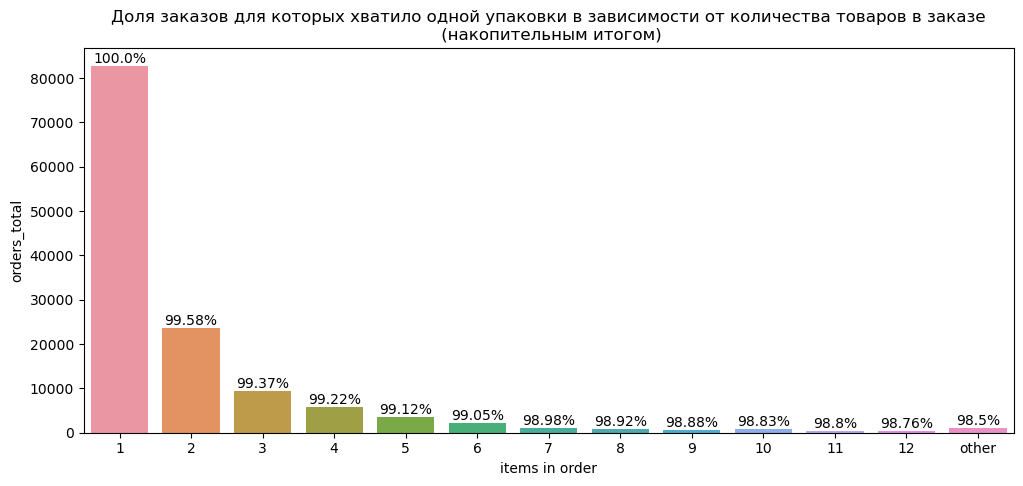

In [30]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=tmp, y='orders_total', x='items_in_order')
values = [str(x) + '%' for x in tmp['share']]
values_orders_onepack = tmp['share']
for i in ax.containers:
    ax.bar_label(i, values)
plt.title('Доля заказов для которых хватило одной упаковки в зависимости от количества товаров в заказе\n (накопительным итогом)')
plt.xlabel('items in order')
None

С увеличением количества товаров в заказе процент заказов по накопительной сумме незначительно уменьшается.

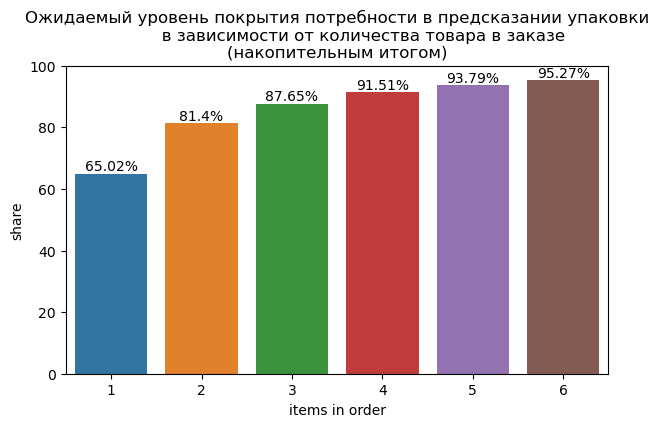

In [31]:
tmp = round(values_orders_onepack[:6] * values_orders_total[:6] / 100, 2)
tmp = pd.DataFrame(data={'share': tmp, 'index': [1, 2, 3, 4, 5, 6]})

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=tmp, y='share', x='index')
values = [str(x) + '%' for x in tmp['share']]

for i in ax.containers:
    ax.bar_label(i, values)
plt.title('Ожидаемый уровень покрытия потребности в предсказании упаковки\n \
          в зависимости от количества товара в заказе \n(накопительным итогом)')
plt.xlabel('items in order')
None

На графике мы видим сопоставление количества товаров в заказах и доли заказов, для которых хватило одной упаковки. Первая группа означает, что если наш алгоритм будет предсказывать упаковку только для заказов с одним товаром в составе, то максимально мы покроем только $65$ % потребности заказчика. Вторая группа означает, что если добавить в алгоритм прогноз упаковки для заказов, состоящих из одного или двух товаров, то мы покроем уже $81.4$ % потребности заказчика с учетом предполагаемых ошибок. Можно протестировать варианты с количеством товаров в заказе до $4$, $5$ или $6$ шт, тогда ожидаемое покрытие потребности будет $91-95$ %.

### 2.3. Упаковка <a class="anchor" id="pack"></a>

Проанализируем колонку `sel_calc_cube`:

In [32]:
carton['carton_volume'] = carton['HEIGHT'] * carton['LENGTH'] * carton['WIDTH']

print(f'Количество разных размеров упаковки из sel_calc_cube: {len(data["sel_calc_cube"].unique())}',
      np.sort(data['sel_calc_cube'].unique()),
      f'Количество разных размеров упаковок по датасету carton: {len(carton["carton_volume"].unique())}',
      np.sort(carton['carton_volume'].unique()),
      sep='\n')

Количество разных размеров упаковки из sel_calc_cube: 38
[     0    998    999   1200   1447   1500   2816   3267   3360   3449
   3705   4068   4560   7600   8436   8525   8600   9000  10836  13125
  13500  15579  18000  18270  18300  21812  26153  26277  26820  27000
  32722  40050  40140  40500  43200  46800 104586 108000]
Количество разных размеров упаковок по датасету carton: 26
[     0.       999.      1500.      2592.      3449.6     3705.
   4292.      8436.      9000.     13125.     15580.     18000.
  26277.3    26820.     40050.     46200.     46800.     58500.
  69600.     72240.     72800.    108000.    144000.    168000.
 263599.875 384000.   ]


В колонке `sel_calc_cube` указано больше разных вариантов объёмов выбранной упаковки, чем имеется в `carton`. Некоторые размеры из `sel_calc_cube`, не входящие в `carton`, близки по значению к имеющимся размерам упаковок. Посмотрим какую упаковку с таким объемом выбирали сотрудники склада, рассмотрим несколько примеров:

In [33]:
sku['item_volume'] = round(sku['a'] * sku['b'] * sku['c'], 2)
data = data.merge(sku, on='sku', how='left') \
           .merge(carton[['CARTONTYPE', 'carton_volume', 'LENGTH', 'WIDTH', 'HEIGHT']],
                  left_on='selected_cartontype',
                  right_on='CARTONTYPE',
                  how='left') \
           .drop('CARTONTYPE', axis=1)

data.loc[(data['sel_calc_cube'] != data['carton_volume']) 
         & (data['items_total'] == 1),
         ['selected_cartontype', 'sel_calc_cube', 'carton_volume', 'LENGTH', 'WIDTH', 'HEIGHT', 'item_volume', 'a', 'b', 'c']] \
    .sample(15, random_state=42)

,selected_cartontype,sel_calc_cube,carton_volume,LENGTH,WIDTH,HEIGHT,item_volume,a,b,c
310045,MYD,7600,15580.0,38.0,50.0,8.20,4241.30,29.20,3.50,41.50
2295,MYD,15579,15580.0,38.0,50.0,8.20,4313.40,14.00,13.00,23.70
9526,MYA,998,999.0,15.0,20.0,3.33,588.00,7.00,7.00,12.00
147808,MYB,3449,3449.6,22.0,32.0,4.90,370.00,14.80,2.50,10.00
157309,MYB,3449,3449.6,22.0,32.0,4.90,168.00,5.00,4.80,7.00
118786,MYB,3449,3449.6,22.0,32.0,4.90,1134.00,3.00,27.00,14.00
264562,MYB,3449,3449.6,22.0,32.0,4.90,165.75,19.50,1.00,8.50
176209,MYD,15579,15580.0,38.0,50.0,8.20,3220.00,4.00,35.00,23.00
243474,MYB,3449,3449.6,22.0,32.0,4.90,636.27,15.20,4.60,9.10
233211,MYB,3449,3449.6,22.0,32.0,4.90,924.00,20.00,3.30,14.00


Размеры указаны разные из-за погрешности округления, большие различия заметны среди упаковок, по габаритам похожих на пакеты - параметр HEIGHT у них не больше 10 см. (сильные расхождения, например, у MYC и MYD).

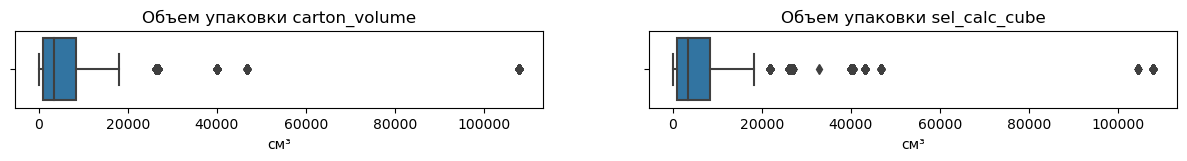

In [34]:
plt.figure(figsize=(15, 1))
cnt = 1
for col in ['carton_volume', 'sel_calc_cube']:
    plt.subplot(1, 2, cnt)
    sns.boxplot(data=data.groupby(by=['orderkey', 'box_num', col])['selected_cartontype']
                        .count()
                        .reset_index(),
                orient='h',
                x=col)
    plt.title('Объем упаковки ' + col)
    plt.xlabel('см\u00B3')
    cnt += 1

Заказы преимущественно упаковывают в небольшую по размерам упаковку, потому что большая часть заказов состоит из одного товара, который, судя по всему, чаще оказывается маленьким. Различия в рассчитанных размерах упаковки на график практически не влияют, медианный объем все равно остается около 5 000 см$^3$.

Проанализируем стоимость упаковки, добавим информацио о виде упаковки (коробка/пакет), полученную от заказчика:

In [35]:
# стоимость упаковки
carton = carton.merge(carton_price, left_on='CARTONTYPE', right_on='Unnamed: 0', how='left') \
               .rename(columns={'01.03.2023': 'price'}) \
               .drop('Unnamed: 0', axis=1)

# объем упаковки на 1 руб. цены
carton['vol_per_price'] = round(carton['carton_volume'] / carton['price'], 2)

# тип упаковки (коробка/пакет)
boxes = ['YMX', 'YML', 'YME', 'YMG', 'YMC', 'YMF', 'YMW', 'YMA', 'MYF', 'YMV', 'YMU']
bags = ['MYE', 'MYD', 'MYC', 'MYB',  'MYA']
carton['pack_type'] = ['box' if x in boxes else 'bag' if x in bags else x for x in carton['CARTONTYPE']]
carton[carton['DISPLAYRFPACK'] == 1].sort_values('HEIGHT')

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK,carton_volume,price,vol_per_price,pack_type
15,NONPACK,0.0,0.0,0.00,1,0.0,NaN,NaN,NONPACK
16,STRETCH,0.0,0.0,0.00,1,0.0,NaN,NaN,STRETCH
24,MYA,15.0,20.0,3.33,1,999.0,1.109861,900.11,bag
17,YMU,27.0,24.0,4.00,1,2592.0,NaN,NaN,box
18,YMV,37.0,29.0,4.00,1,4292.0,NaN,NaN,box
25,MYB,22.0,32.0,4.90,1,3449.6,2.297432,1501.50,bag
21,MYF,20.0,15.0,5.00,1,1500.0,4.083130,367.37,box
26,MYC,30.0,38.0,7.40,1,8436.0,3.616713,2332.50,bag
27,MYD,38.0,50.0,8.20,1,15580.0,6.918375,2251.97,bag
28,MYE,43.0,63.0,9.70,1,26277.3,8.062722,3259.11,bag


Если сравнить объем упаковки на рубль между пакетами и коробками, то можно сделать следующие выводы:
- объем маленького пакета стоит дороже, чем в большого;
- объем коробки дороже объема большого пакета.

По двум видам коробок не указана цена - `YMU` и `YMV`. Ближайшая похожая по размерам коробка `YMA` стоит $4.392937$. Присвоим и им эту цену для дальнейшего приближенного подсчета бизнес-метрики. `NONPACK` и `STRETCH` считаем бесплатными.

In [36]:
carton.loc[carton['CARTONTYPE'] == 'YMU', 'price'] = 4.392937
carton.loc[carton['CARTONTYPE'] == 'YMV', 'price'] = 4.392937
carton.loc[carton['CARTONTYPE'] == 'NONPACK', 'price'] = 0
carton.loc[carton['CARTONTYPE'] == 'STRETCH', 'price'] = 0

In [37]:
# выгрузим таблицу с упаковками и ценами для контейнера
# carton_edited = carton.loc[(carton['DISPLAYRFPACK'] == 1), ['CARTONTYPE', 'LENGTH', 'WIDTH', 'HEIGHT', 'pack_type', 'price']]
# carton_edited.to_csv('carton_edited.csv', index=False)

**Выводы:**
  
*Текущая модель и датасеты*
- выбранная пользователем и предложенная текущей моделью упаковка совпадает примерно в $25$ % случаев;
- количество заказов составляет $159$ $899$ шт.;
- $65$ % заказов состоят из одного товара, $97$ % заказов включает не более $5$ товаров;
- каждый заказ в нашем датасете был собран на одном складе;
- практически каждый заказ собирается одним сборщиком;
- только $4,09$ % всех заказов не помещается в одну упаковку, при этом без учета товаров, для которых упаковщики выбирали `STRETCH` или `NONPACK`, этот процент снижается до $1.27$ %;
- варианты моделей с количеством товаров в заказе до $4$, $5$ или $6$ шт. покроют потребности заказчика на $91-95$ %.

*Упаковка*
- сильные расхождения размеров у упаковок `MYC`, `YMA` и `MYD`;
- заказы преимущественно упаковывают в небольшую по размерам упаковку;
- медианный объем упаковок около $5$ $000$ см3;
- коробкам `YMU` и `YMV` присвоили цену ближайшей похожей по размеру коробки `YMA`, `NONPACK` и `STRETCH` будем считать бесплатными упаковками.

## 3. Подготовка датасета <a class="anchor" id="dataset"></a>

### 3.1. Датасет для заказов с 1 товаром <a class="anchor" id="dataset_1"></a>

Соберем словарь с sku товара и самой дешевой и частовыбираемой пользователем упаковкой для этого товара. Поставим ограничение, чтобы данный товар в датасете в заказах с одним товаром встречался не менее $5$ раз:

In [38]:
# номера заказов с одним товаром
one_item_orders = items_in_orders.loc[items_in_orders['items_total'] == 1, 'orderkey'].values
tmp_data = data[data['items_total'] == 1]

# добавим количество sku в train_data
sku_one_item_amt = tmp_data.groupby('sku')['selected_cartontype'] \
                           .count() \
                           .reset_index() \
                           .rename(columns={'selected_cartontype': 'num_sku_in_table'})
tmp_data = tmp_data.merge(sku_one_item_amt, on='sku', how='left')

# посмотрим сколько уникальных товаров у нас получилось
len(tmp_data.loc[tmp_data['num_sku_in_table'] >= 5, 'sku'].unique())

3365

Найдем моду по выбранным упаковкам, возьмем самую дешевую (если моды $2$) и составим из полученных данных словарь вида `{sku: упаковка}`. Создадим новую колонку со скорректированным таргетом.

In [39]:
sku_340 = set(sku_cargotypes.loc[sku_cargotypes['cargotype'] == 340, 'sku'].values)
sku_360 = set(sku_cargotypes.loc[sku_cargotypes['cargotype'] == 360, 'sku'].values)

sku_list = tmp_data.loc[tmp_data['num_sku_in_table'] >= 5, 'sku'].unique()
sku_pack_dict = {}
for i in sku_list:
    selected_pack_mode = tmp_data.loc[tmp_data['sku'] == i, 'selected_cartontype'].mode().tolist()
    p = selected_pack_mode[0]
    if len(selected_pack_mode) > 1:
        for pack in selected_pack_mode:
            if (carton.loc[carton['CARTONTYPE'] == pack, 'price'].values[0]
                < carton.loc[carton['CARTONTYPE'] == p, 'price'].values[0]):
                p = pack
        sku_pack_dict[i] = p
    else:
        sku_pack_dict[i] = p

# добавляем колонку target, которую скорректируем с помощью словарей
data['target'] = data['selected_cartontype'].values

def replace_pack(row):
    """
    Принимает на вход строку датасета, проверяет на наличие карготипов в словарях  
    sku_340 и sku_360 и возвращает 'NONPACK' или 'STRETCH' соответственно. Если карготипы не найдены,
    то ищет значение из колонки 'sku' в словаре sku_pack_dict:
    - если значение найдено, возвращает значение из словаря по указанному ключу;
    - в остальных случаях, возвращает значение из колонки 'selected_cartontype'.
    """
    if row['sku'] in sku_340:
        return 'NONPACK'
    
    elif row['sku'] in sku_360:
        return 'STRETCH'
    
    elif row['sku'] in sku_pack_dict:
        return sku_pack_dict[row['sku']]
    
    else:
        return row['selected_cartontype']
  
# заменяем значения
data.loc[data['items_total'] == 1, 'target'] = data[data['items_total'] == 1].progress_apply(replace_pack, axis=1)

# выгрузим словарь для контейнера
# with open('sku_pack_dict.json', 'w') as fp:
#     json.dump(sku_pack_dict, fp)

# проверяем selected_cartontype и target после на примере
print(data[data['selected_cartontype'] != data['target']].shape[0])
data[(data['sku'] == '6287a74b664fd8ad4ed5c541b399a82b') & (data['items_total'] == 1)]

100%|██████████| 103970/103970 [00:00<00:00, 107860.33it/s]


34802


,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,items_total,a,b,c,item_volume,carton_volume,LENGTH,WIDTH,HEIGHT,target
14,0,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,2310d9f42adf2d66fb086d4c73d427e4,6672826678229ee7a3de3b84b905fd59,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH
8177,0,01277a58f3aa98c06db9046699ec162d,MYE,1,MYD,26277,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,03aacbad58f757f2b1bf608c004932c2,87b6d2471c093998b982a4c434df8da6,1,18.6,3.3,49.7,3050.59,26277.3,43.0,63.0,9.7,STRETCH
54690,0,19ca05955536663c48d156fdb245576f,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,5485873db484d8b7da11f121a814d87f,13ec77ce4d743526fa8e919bb05e3809,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH
130578,0,d258fbbbd845ce5a1544bae832787d7f,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,96b0913ee1b2141d1c82e6eb4c9a28ce,2664f42465ded1f8462b667512d6a3bd,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH
161175,0,9816957a517c387a304741f416e3eb06,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,96b0913ee1b2141d1c82e6eb4c9a28ce,1eeea70cf1b23ef3f15ce6b89eac2adf,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH
164854,0,3a2bd475ed6b5f18010267ee67c2944c,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,96b0913ee1b2141d1c82e6eb4c9a28ce,6c45f5801acf41ea3585316e38efe460,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH
196675,0,3a812e9be7cb3c641ef8c2a80fd7ef87,MYD,1,MYD,15579,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,3be170dbc6c5761fb2d9f51fc2d3fcd3,3bf6e39e8dc3ba16277dfb4f47e0314b,1,18.6,3.3,49.7,3050.59,15580.0,38.0,50.0,8.2,STRETCH


В примере видно, что для заказов с одним товаром с sku `6287a74b664fd8ad4ed5c541b399a82b` чаще выбиралась упаковка в пленку, но были и случаи упаковки в пакет. Мы заменили таргет в данном случае на пленку.
Таким образом было скорректировано $34$ $802$ значения, это примерно $21.7$ % всех заказов и $33.5$ % заказов с одним товаром.

Добавим стоимость упаковки для скорректированного таргета и для выбранной пользователем упаковки. Посчитаем получившуюся разницу в затратах для заказов с одним товаром и долю экономии по затратам на все заказы:

In [40]:
data = data.merge(carton[['CARTONTYPE', 'price']], left_on='target', right_on='CARTONTYPE', how='left') \
           .rename(columns={'price': 'target_price'}) \
           .merge(carton[['CARTONTYPE', 'price']], left_on='selected_cartontype', right_on='CARTONTYPE', how='left') \
           .rename(columns={'price': 'selected_cartontype_price'}) \
           .drop(['CARTONTYPE_x', 'CARTONTYPE_y'], axis=1)

# таблица для подсчета общих затрат на упаковку пользователями
tmp = data.groupby(['orderkey', 'box_num', 'selected_cartontype'])['recommended_cartontype'] \
          .count() \
          .reset_index() \
          .rename(columns={'recommended_cartontype': 'pack_amt'}) \
          .merge(carton[['CARTONTYPE', 'price']], left_on='selected_cartontype', right_on='CARTONTYPE', how='left')


costs_employee = round((tmp['pack_amt'] * tmp['price']).sum(), 2)
# здесь не берем срез по 1 товару, тк другие данные мы не меняли
cost_savings = round(data['selected_cartontype_price'].sum() - data['target_price'].sum(), 2)

print(f'Затраты до оптимизации, по всем заказам: {costs_employee}',
      f'Экономия в руб.: {cost_savings}',
      f'Экономия в %: {round(cost_savings / costs_employee * 100, 2)}',
      sep='\n')

Затраты до оптимизации, по всем заказам: 2193243.12
Экономия в руб.: 116144.01
Экономия в %: 5.3


С помощью нехитрой корректировки удалось снизить затраты на $116$ $144$ руб. или на $5.3$ % от общих затрат. Посмотрим на распределение целевой переменной до и после корректировки. смотреть доли будем относительно общего количества заказов:

In [41]:
def bar_plot(df, group_column, title, xlabel='', drop_name="NONPACK", drop_first=False, denominator=items_in_orders.shape[0]):
    """
    Строит столбчатую диаграмму по агрегированным данным
    """
    tmp = df.groupby([group_column])['orderkey'] \
            .count() \
            .reset_index() \
            .rename(columns={'orderkey': 'amount'}) \
            .sort_values('amount', ascending=False)

    tmp['share'] = round(tmp['amount'] / denominator * 100, 2)
    values = [str(x) + '%' for x in tmp['share']]

    if drop_first:
        print(f'Доля {drop_name} среди предсказаний: {tmp.loc[tmp[group_column] == drop_name, "share"].values[0]}')
        ax = sns.barplot(data=tmp[tmp[group_column] != drop_name],
                         x=group_column,
                         y='amount')
        for i in ax.containers:
            ax.bar_label(i, values[1:])
    else:
        ax = sns.barplot(data=tmp, 
                         x=group_column,
                         y='amount')
        for i in ax.containers:
            ax.bar_label(i, values[:])
    plt.title(title)
    plt.xlabel(xlabel)

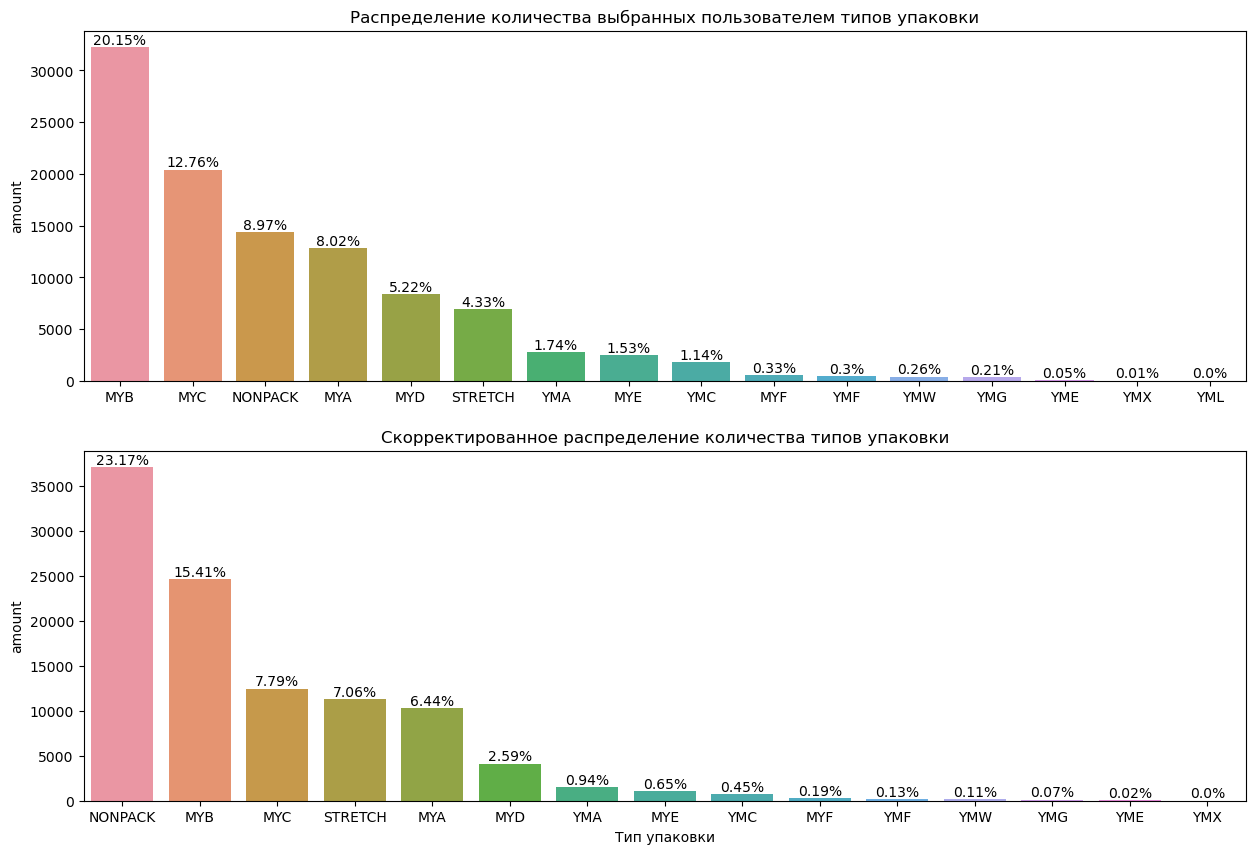

In [42]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
bar_plot(data[data['items_total'] == 1],
         'selected_cartontype',
         'Распределение количества выбранных пользователем типов упаковки')

plt.subplot(2, 1, 2)
bar_plot(data[data['items_total'] == 1],
         'target',
         'Скорректированное распределение количества типов упаковки',
         'Тип упаковки')

По графикам видно, что подавляющее большинство упаковок для товаров из одного заказа, это пакеты ($47.7$ % из $65$ % по выбору упаковщиков и $32.88$ % из $65$ % по скорректированному таргету). Вместе с заказами с `NONPACK` и `STRETCH` это примерно $63$ % из $65$ % всех заказов. Можно сделать вывод, что алгоритм, проверяющий карготипы `340` и `360`, и при их отсутствии сверяющий размеры товара и упаковки и выбирающий самую дешевую из подходящих, подберет подходящий по размерам пакет (в редких случаях это будет коробка). При этом пакет будет подобран самый дешевый из имеющихся, что поможет сократить расходы.

### 3.2. Датасет для заказов с 2-5 товарами <a class="anchor" id="dataset_2-5"></a>

Возьмем срез заказов с 2-5 товарами в составе и посчитаем их количсетво:

In [43]:
tmp_data = data[(data['items_total'] > 1) & (data['items_total'] < 6)]
print(f'Всего заказов с 2-5 товарами: {len(tmp_data["orderkey"].unique())}')

Всего заказов с 2-5 товарами: 47332


Добавим информацию о карготипах `340` и `360` в датасет:

In [44]:
def cargotypes(row):
    '''
    Возвращает 1 для ячейки первой колонки, если карготип товара 340,
    и 1 для ячейки второй колонки, если карготип товара 360.
    Если у товара нет какого-то из указанных карготипов, возвращает 0
    в ячейку соответствующей колонки.
    '''
    cnt_340 = 0
    cnt_360 = 0
    if row['sku'] in sku_340:
        cnt_340 += 1
    if row['sku'] in sku_360:
        cnt_360 += 1
    return pd.Series([cnt_340, cnt_360])

tmp_data[['340', '360']] = tmp_data.progress_apply(cargotypes, axis=1)

100%|██████████| 129333/129333 [00:12<00:00, 10694.01it/s]


In [45]:
tmp = tmp_data[(tmp_data['340'] == 1) | (tmp_data['360'] == 1)].groupby(['orderkey', 'items_total'])['sku'] \
            .count() \
            .reset_index() \
            .rename(columns={'sku': 'num_items'})
orders_to_filter = set(tmp.loc[tmp['items_total'] == tmp['num_items'], 'orderkey'].values)

# посчитаем, какая экономия получается для заказов из 2-5 товаров, если все товары в заказе имеют карготип 340 и/или 360
economy = round(data[data['orderkey'].isin(orders_to_filter)]
                    .groupby(['orderkey', 'box_num', 'selected_cartontype_price'])['whs']
                    .count()
                    .reset_index()
                    ['selected_cartontype_price'].sum(), 2)

print(f'Всего заказов с карготипами 340 и 360 в составе: {tmp.shape[0]}',
      f'Заказов только с карготипами 340 и 360: {len(orders_to_filter)}',
      f'Экономия: {economy}',
      sep='\n')

Всего заказов с карготипами 340 и 360 в составе: 27840
Заказов только с карготипами 340 и 360: 16970
Экономия: 110541.86


$16$ $970$ заказов, в которых содержатся только товары с карготипами `340` и/или `360`. Это примерно $10.6$ % датасета. Мы будем предсказывать для таких заказов соответствующую карготипу упаковку `NONPACK` и/или `STRETCH`. Значит, после подсчета точности на заказах с одним товаром и остальных заказах с 2-5 товарами к accuracy нашего алгоритма прибавим $10.6$ %.   
За счет предсказания `NONPACK` и `STRETCH` по указанным выше заказам получается сэкономить $110$ $541.86$ руб.  
Сформируем датасет для обучения модели на заказах с 2-5 товарами по оставшимся данным:

In [46]:
# оставим заказы, в составе которых есть хотя бы один товар без карготипа 340 и 360
tmp_data = tmp_data[~tmp_data['orderkey'].isin(orders_to_filter)]

tmp = []
for _, order in tmp_data.groupby('orderkey'):
    row = []
    row += [order.iloc[0,1]]
    for i in order.index:
        row += [order.loc[i,'a'],
                order.loc[i,'b'],
                order.loc[i,'c'],
                order.loc[i,'a'] * order.loc[i, 'b'] * order.loc[i, 'c'],
                order.loc[i,'goods_wght']]
    if len(row) < 26:
        row += [0] * (26 - len(row))

 # выбираем для таргета моду по упаковке из заказа
    selected_pack_mode = order['selected_cartontype'].mode().tolist()
    p = selected_pack_mode[0]
    if len(selected_pack_mode) > 1:
        for pack in selected_pack_mode:
            if (carton.loc[carton['CARTONTYPE'] == pack, 'price'].values[0]
                < carton.loc[carton['CARTONTYPE'] == p, 'price'].values[0]):
                    p = pack
    row += [p]
    tmp.append(row)

columns = ['orderkey', 'a1', 'b1', 'c1', 'vol1', 'wght1',
           'a2', 'b2', 'c2', 'vol2', 'wght2',
           'a3', 'b3', 'c3', 'vol3', 'wght3',
           'a4', 'b4', 'c4', 'vol4', 'wght4',
           'a5', 'b5', 'c5', 'vol5', 'wght5',
           'target'
           ]
ml_data = pd.DataFrame(data=tmp, columns=columns)
# из-за пропущенных значений в габаритах некоторых товаров, появляются пропуски, заполним их 0
ml_data = ml_data.fillna(0)
print(ml_data.shape)
ml_data.head()

(30362, 27)


,orderkey,a1,b1,c1,vol1,wght1,a2,b2,c2,vol2,wght2,a3,b3,c3,vol3,wght3,a4,b4,c4,vol4,wght4,a5,b5,c5,vol5,wght5,target
0,0000fc4c7acac6e89f82392b90e47a27,6.0,6.0,22.0,792.000,0.200,8.0,6.0,13.0,624.000,0.200,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,MYB
1,00099f64a295d92e9d3f844629542d97,3.0,19.0,6.0,342.000,0.500,7.2,21.6,4.9,762.048,0.465,17.0,3.0,8.0,408.0,0.166,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,MYC
2,0009c9475ffa24943b4654b9c35c6391,17.0,13.0,9.0,1989.000,0.490,17.0,13.0,9.0,1989.000,0.490,22.6,8.0,27.5,4972.0,0.856,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,MYD
3,000cef2ced8b3c5e5a269d7fe1ca356d,8.8,7.4,15.3,996.336,0.127,11.0,18.0,7.0,1386.000,0.280,6.0,16.0,9.0,864.0,0.250,5.0,14.5,14.0,1015.0,0.075,0.0,0.0,0.0,0.0,0.0,MYC
4,000f343df4b8fd43143bf5ff156dca9b,5.7,26.3,9.9,1484.109,0.540,20.3,8.5,15.3,2640.015,0.353,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,YMF


**Выводы:** 

- составлен и сохранен для контейнера словарь sku_pack_dict, в котором содержится историческая информация об упаковке, выбранной пользователями для заказов с одним товаром;
- на основе исторических данных скорректировано $34$ $802$ значения целевой переменной или $21.7$ % всех заказов и $33.5$ % заказов с одним товаром;
- большинство выбранных упаковок для заказов с одним товаром - это пакеты, вместе с заказами с `NONPACK` и `STRETCH` это примерно $63$ % из $65$ % всех заказов;
- $10.6$ % датасета составляют заказы из 2-5 товаров, где все товары имею карготип `NONPACK` и/или `STRETCH`. Затраты на упаковку таких заказов составляют $110$ $541.86$ руб;
- размер итогового датасета для обучения модели составил $30$ $362$ заказа или примерно $19$ % от изначального датасета;
- размер датасета для алгоритма подбора упаковки по карготипу, историческим данным и размерам товара составил $103$ $970$ заказов или $65$ % от изначального датасета;
- таким образом наш алгоритм будет стараться предсказывать упаковку примерно для $94.6$ % изначального датасета.

## 4. Алгоритмы <a class="anchor" id="algorithms"></a>

### 4.1. Алгоритм для заказов из одного товара <a class="anchor" id="one_item"></a>
Возьмем срез с заказами из одного товара и сделаем предсказания. Будем придерживаться следующей логики:
- сначала проверяем карготипы товаров `340` и `360` - если присутствуют, то возвращаем `NONPACK` или `STRETCH` соответственно;
- если указанных карготипов нет, смотрим на исторические данные по упаковке таких товаров (в словаре sku_pack_dict собраны самые дешевые моды упаковки для sku товаров, если моды было две);
- размеры товара и коробки будем сравнивать поэлементно (минимальный с минимальным, максимальный с максимальным, медианный с медианным);
- для пакета сравним диаметр его окружности в раскрытом состоянии с диагональю меньшей грани товара-прямоугольного параллелепипеда, а также высоту пакета и товара. К диагонали и высоте товара прибавим $10$ % и $20$ % соответственно, чтобы товар помещался в пакет без усилий;
- за сторону пакета с отверстием возьмем параметр `LENGTH`, как среднюю величину (по личным наблюдениям за пропорциями пакетов из доставки);
- неподошедшие по сравнению диагонали и диаметра пакеты будем сравнивать с товарами по линейным размерам;
- после сравнения выбираем самую дешевую из подходящих упаковок.

Посчитаем accuracy по предсказаниями упаковки для заказов с одним товаром и % верных предсказаний относительно общего количества заказов:

In [47]:
one_item_data = data[data['items_total'] == 1].reset_index(drop=True)


def one_item_classifier(row):
    """
    Принимает на вход строку датасета, проверяет на наличие карготипов в словарях  
    sku_340 и sku_360 и возвращает 'NONPACK' или 'STRETCH' соответственно. Если карготипы не найдены,
    то ищет значение из колонки 'sku' в словаре sku_pack_dict:
    - если значение найдено, возвращает значение из словаря по указанному ключу;
    - в остальных случаях, сравнивает размеры товара и упаковок, выбирает самую дешевую
      упаковку из подходящих по размеру;
    - если отсутствуют размеры товара, возвращает 'no_size';
    - если подходящей упаковки нет, возвращает 'no_valid_pack'.
    """
    boxes = ['YMA', 'YMC', 'YME', 'YMF', 'YMG', 'YML',
             'YMU', 'YMV', 'YMW', 'MYF', 'YMX',]
    bags = ['MYA', 'MYB', 'MYC', 'MYD', 'MYE']
    
    if row['sku'] in sku_340:
        return 'NONPACK'
    
    elif row['sku'] in sku_360:
        return 'STRETCH'
    
    # если по товару есть статистика, во что его чаще всего упаковывают, берем значение из словаря
    elif row['sku'] in sku_pack_dict:
        return sku_pack_dict[row['sku']]
    
    # иначе проверяем в какую из имеющихся упаковок влезет товар и выбираем самую дешевую
    else:
        if not (row['a'] and row['b'] and row['c']):
            return 'no_size'
        valid_pack = []
        for pack in boxes:
            if (np.min(row[['a', 'b', 'c']].values)
                < np.min(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)
                and np.max(row[['a', 'b', 'c']].values)
                < np.max(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)
                and np.median((row[['a', 'b', 'c']]).values)
                < np.median(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)):
                valid_pack.append(pack)
        for pack in bags:
            if (1.2 * np.max(row[['a', 'b', 'c']].values)
                < carton.loc[carton['CARTONTYPE'] == pack, 'WIDTH'].values
                and 1.1 * np.sqrt(np.min(row[['a', 'b', 'c']].values)**2 + np.median((row[['a', 'b', 'c']]).values)**2)
                < 2 * carton.loc[carton['CARTONTYPE'] == pack, 'LENGTH'].values / np.pi):
                valid_pack.append(pack)
        for pack in bags:
            if (not pack in valid_pack and np.min(row[['a', 'b', 'c']].values)
                < np.min(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)
                and np.max(row[['a', 'b', 'c']].values)
                < np.max(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)
                and np.median((row[['a', 'b', 'c']]).values)
                < np.median(carton.loc[carton['CARTONTYPE'] == pack,['LENGTH', 'WIDTH', 'HEIGHT']].values)):
                valid_pack.append(pack)
        if len(valid_pack) == 0:
            return 'no_val_pack'
        return carton.loc[carton['CARTONTYPE'].isin(valid_pack), ['CARTONTYPE', 'price']] \
                     .sort_values('price')['CARTONTYPE'] \
                     .tolist()[0]
    
one_item_data['predict'] = one_item_data.progress_apply(one_item_classifier, axis=1)
print(f'Accuracy по заказам с одним товаром: {round((one_item_data["predict"] == one_item_data["target"]).mean(), 2)}',
      f'% от общего количества заказов: {round((one_item_data["predict"] == one_item_data["target"]).sum() / 159899 * 100, 2)}',
      sep='\n')
one_item_data.head()

100%|██████████| 103970/103970 [18:21<00:00, 94.41it/s] 

Accuracy по заказам с одним товаром: 0.7
% от общего количества заказов: 45.24


,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,items_total,a,b,c,item_volume,carton_volume,LENGTH,WIDTH,HEIGHT,target,target_price,selected_cartontype_price,predict
0,0,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,STRETCH,1,MYD,0,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,2310d9f42adf2d66fb086d4c73d427e4,6672826678229ee7a3de3b84b905fd59,1,18.6,3.3,49.7,3050.59,0.0,0.0,0.0,0.0,STRETCH,0.0,0.0,STRETCH
1,0,3e646181f6f708edd3326c1626c12d23,STRETCH,1,YMG,0,13662,26820,4.400,ef468fa349bb8f058aa5dcd76bda60b2,2310d9f42adf2d66fb086d4c73d427e4,33350ad810725c4a482e3cc9ee1dbdf9,1,30.0,23.0,22.0,15180.00,0.0,0.0,0.0,0.0,NONPACK,0.0,0.0,NONPACK
2,0,7047c16a6b7c120162ca3da0ebca43fd,STRETCH,1,MYE,0,4518,26277,0.700,d714bc5c946ec01d9b09714524805e5c,2310d9f42adf2d66fb086d4c73d427e4,7ed1b5831b995ebca234ead10d4f6cf4,1,14.0,10.7,43.8,6561.24,0.0,0.0,0.0,0.0,NONPACK,0.0,0.0,NONPACK
3,0,097917e584151c0c21f205b2c3aafa10,STRETCH,1,YMF,0,6346,13125,2.078,eb0e661f3ed57ef7ca16418bf50e363e,2310d9f42adf2d66fb086d4c73d427e4,569157f429977b628d3d56ae963f0683,1,23.4,8.0,33.9,6346.08,0.0,0.0,0.0,0.0,STRETCH,0.0,0.0,STRETCH
4,0,1d11d793924acefde0b7f2ad149e1b45,NONPACK,1,YMX,0,21150,46800,6.020,0588e43ea7ad1ef603059269db6467eb,2310d9f42adf2d66fb086d4c73d427e4,53b1e7248be0cb6108a9adf90a5f17ec,1,30.0,47.0,15.0,21150.00,0.0,0.0,0.0,0.0,NONPACK,0.0,0.0,NONPACK


Точность предсказаний составила $0.7$ по заказам с одним товарам, а всего по датасету мы верно предсказали упаковку для $45.24$ % заказов. Проанализируем оставшиеся $20$ % заказов с одним товаром - возможно, наша модель предсказала пакет большего или меньшего размера, чем выбирал упаковщик (или коробку другого размера, в случаях, если упаковщик тоже выбирал коробку), тогда, если мы принимаем логику сравнения размеров товара и упаковки за верную, это тоже будет верный ответ, влияющий только на затраты на упаковку. Посмотрим на распределение предсказаний по типу упаковки:

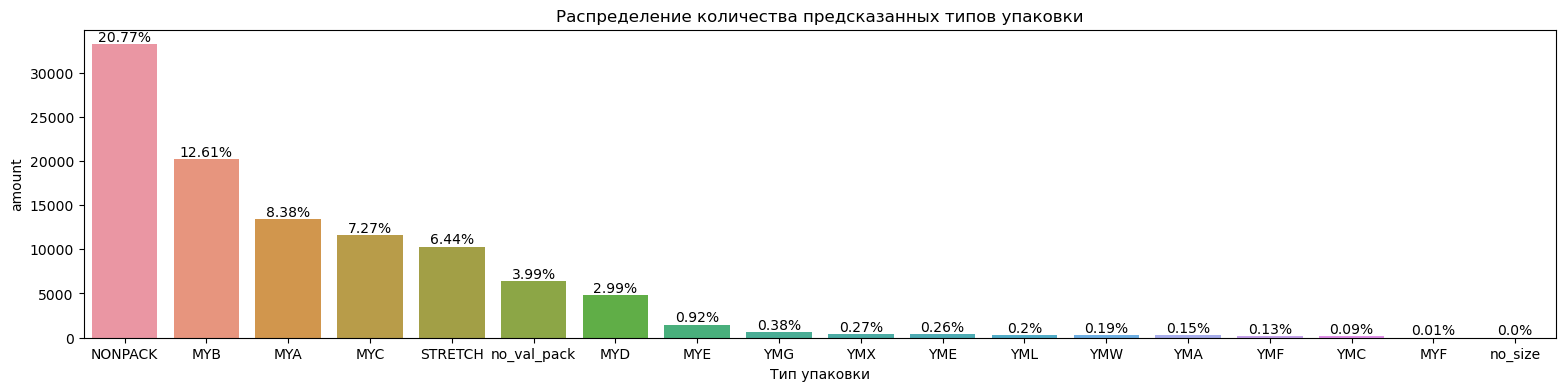

In [48]:
plt.figure(figsize=(19, 4))
bar_plot(one_item_data,
        'predict',
        'Распределение количества предсказанных типов упаковки',
        'Тип упаковки',
        drop_first=False)

По сравнению со скорректированным распределением количества типов упаковки, немного снизилась доля `MYB` и `MYC`, возросла доля `MYA`. Для $4$% товаров алгоритм не смог подобрать упаковку, вероятно они были слишком большие, но карготипы `340` и `360` отсутствовали.

#### 4.1.1. Подсчет экономии и % верных предсказаний <a class="anchor" id="one_item_savings"></a>

Посмотрим подробнее что выбирали пользователи для каждого предсказанного вида упаковки из наибольших по доле (кроме `NONPACK` и `STRETCH`). Выведем доли относительно общего количества заказов в датасете, чтобы потом просто прибавить подходящие позиции к итоговой accuracy.

In [49]:
add_accuracy = 0
for pack in ['MYB', 'MYA', 'MYC', 'no_val_pack', 'MYD', 'MYE']:
    print(pack, ':')
    tmp = one_item_data[one_item_data['predict'] == pack].groupby('selected_cartontype')['box_num'] \
                                                    .count() \
                                                    .reset_index() \
                                                    .rename(columns={'box_num': 'amt'}) \
                                                    .sort_values('amt', ascending=False) \
                                                    .merge(carton[['CARTONTYPE', 'pack_type']],
                                                           left_on='selected_cartontype',
                                                           right_on='CARTONTYPE',
                                                           how='left')
    tmp['share'] =  round(tmp['amt'] / items_in_orders.shape[0] * 100, 2)
    if pack != 'no_val_pack':
        curr_pack_type = tmp.loc[tmp['selected_cartontype'] == pack, 'pack_type'].values[0]
        # исключим из суммы % совпадающих с таргетом предсказаний, т.к. это уже входит в рассчитанную accuracy
        acc  = tmp.loc[(tmp['pack_type'] == curr_pack_type) & (tmp['selected_cartontype'] != pack), 'share'].values.sum()
        add_accuracy += acc
        print(f'Accuracy + {round(acc, 2)} %')
    display(tmp)
print(f'Всего добавить к accuracy: {round(add_accuracy, 2)} %')

MYB :
Accuracy + 3.86 %


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,MYB,12775,MYB,bag,7.99
1,MYC,3645,MYC,bag,2.28
2,MYA,2233,MYA,bag,1.40
3,YMA,752,YMA,box,0.47
4,MYD,245,MYD,bag,0.15
5,MYF,142,MYF,box,0.09
6,YMC,142,YMC,box,0.09
7,NONPACK,86,NONPACK,NONPACK,0.05
8,STRETCH,67,STRETCH,STRETCH,0.04
9,MYE,47,MYE,bag,0.03


MYA :
Accuracy + 4.16 %


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,MYA,6373,MYA,bag,3.99
1,MYB,5852,MYB,bag,3.66
2,MYC,713,MYC,bag,0.45
3,YMA,159,YMA,box,0.10
4,MYF,134,MYF,box,0.08
5,MYD,62,MYD,bag,0.04
6,NONPACK,45,NONPACK,NONPACK,0.03
7,MYE,17,MYE,bag,0.01
8,STRETCH,17,STRETCH,STRETCH,0.01
9,YMC,16,YMC,box,0.01


MYC :
Accuracy + 3.25 %


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,MYC,5350,MYC,bag,3.35
1,MYB,3386,MYB,bag,2.12
2,MYD,1162,MYD,bag,0.73
3,MYA,509,MYA,bag,0.32
4,YMA,423,YMA,box,0.26
5,YMC,305,YMC,box,0.19
6,NONPACK,134,NONPACK,NONPACK,0.08
7,MYE,131,MYE,bag,0.08
8,STRETCH,106,STRETCH,STRETCH,0.07
9,YMF,48,YMF,box,0.03


no_val_pack :


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,NONPACK,2947,NONPACK,NONPACK,1.84
1,MYB,1183,MYB,bag,0.74
2,MYA,779,MYA,bag,0.49
3,MYC,695,MYC,bag,0.43
4,MYD,241,MYD,bag,0.15
5,STRETCH,199,STRETCH,STRETCH,0.12
6,MYE,134,MYE,bag,0.08
7,YMA,50,YMA,box,0.03
8,YMC,43,YMC,box,0.03
9,YMG,37,YMG,box,0.02


MYD :
Accuracy + 1.61 %


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,MYC,1611,MYC,bag,1.01
1,MYD,1548,MYD,bag,0.97
2,MYB,593,MYB,bag,0.37
3,MYE,246,MYE,bag,0.15
4,YMC,174,YMC,box,0.11
5,NONPACK,163,NONPACK,NONPACK,0.10
6,MYA,134,MYA,bag,0.08
7,STRETCH,124,STRETCH,STRETCH,0.08
8,YMF,68,YMF,box,0.04
9,YMA,55,YMA,box,0.03


MYE :
Accuracy + 0.58 %


,selected_cartontype,amt,CARTONTYPE,pack_type,share
0,MYD,412,MYD,bag,0.26
1,MYC,298,MYC,bag,0.19
2,MYE,207,MYE,bag,0.13
3,MYB,165,MYB,bag,0.10
4,STRETCH,128,STRETCH,STRETCH,0.08
5,NONPACK,102,NONPACK,NONPACK,0.06
6,MYA,49,MYA,bag,0.03
7,YMC,31,YMC,box,0.02
8,YMW,28,YMW,box,0.02
9,YMF,23,YMF,box,0.01


Всего добавить к accuracy: 13.46 %


По срезам видно, что для предсказанных пакетов `MYB` пользователи чаще выбирали близкие по размеру пакеты `MYB`, `MYC` и `MYA`; для `MYA` это были преимущественно `MYA` и `MYB`, для `MYC` - `MYC`, `MYB` и `MYD`. Такая же картина и для остальных рассмотренных пакетов - выбор пользователя был близок по размеру к предсказанному алгоритмом пакету. Добавим эти случаи к нашей accuracy и получим $69.3$ % точности ($45.24 $ %$+ 13.46 $ % + $10.6$ %).  
Посчитаем экономию на заказах с одним товаром:

In [50]:
one_item_data = one_item_data.merge(carton[['CARTONTYPE', 'price']], left_on='predict', right_on='CARTONTYPE', how='left') \
                             .rename(columns={'price': 'predicted_price'}) \
                             .drop('CARTONTYPE', axis=1)

cost_savings = round(one_item_data['selected_cartontype_price'].sum() - one_item_data['predicted_price'].sum(), 2)

print(f'Затраты до оптимизации, по всем заказам: {costs_employee}',
      f'Экономия в руб.: {cost_savings}',
      f'Экономия в %: {round(cost_savings / costs_employee * 100, 2)}',
      sep='\n')

Затраты до оптимизации, по всем заказам: 2193243.12
Экономия в руб.: 85889.33
Экономия в %: 3.92


Получилась экономия $85$ $889$ руб. или $3.92$ % от всех затрат.

### 4.2. ML-подход для заказов из 2-5 товаров <a class="anchor" id="2-5"></a>

Посмотрим на распределение целевой переменной:

In [51]:
ml_data['target'].value_counts()

MYC        6681
MYB        6627
YMC        3293
MYD        2896
YMA        2425
MYA        1867
YMF        1535
YMW        1125
NONPACK    1039
MYE         938
YMG         895
STRETCH     568
MYF         220
YME         212
YMX          24
YML          17
Name: target, dtype: int64

Данные несбалансированы, это было ожидаемо, учитывая статистику по упаковке. Для нашей задачи важно точно предсказывать как можно больше случаев, а не классов, чтобы сэкономить больше времени упаковщикам. Поэтому будем оценивать качество модели по f1 micro - аналогу accuracy. Разделим датасет на обучающую и тестовую части и подберем параметры модели LGBMClassifier:

In [52]:
X = ml_data.drop('target', axis=1)
Y = ml_data['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ml_data['target']
                                                    )

print('X_train:',X_train.shape, '\n',
      'X_test:', X_test.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'y_test:', y_test.shape)

X_train: (24289, 26) 
 X_test: (6073, 26) 
 y_train: (24289,) 
 y_test: (6073,)


In [53]:
num_classes = len(ml_data['target'].unique())
model_lgbm = LGBMClassifier(random_state=SEED, objective='multiclass', num_classes=num_classes, metric='multi_logloss')
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [20, 30, 40, 50, 60, 70, 90, 110]
              }
grid = GridSearchCV(model_lgbm, param_grid=param_grid, cv=5, scoring='f1_micro', verbose=0)
grid.fit(X_train.drop('orderkey', axis=1), y_train)

print(f'f1_micro: {round(grid.best_score_, 4)}',
      'Наилучшие параметры:',
      f'max_depth: {grid.best_params_["max_depth"]}',
      f'n_estimators: {grid.best_params_["n_estimators"]}',
      sep='\n')

f1_micro: 0.3924
Наилучшие параметры:
max_depth: 6
n_estimators: 40


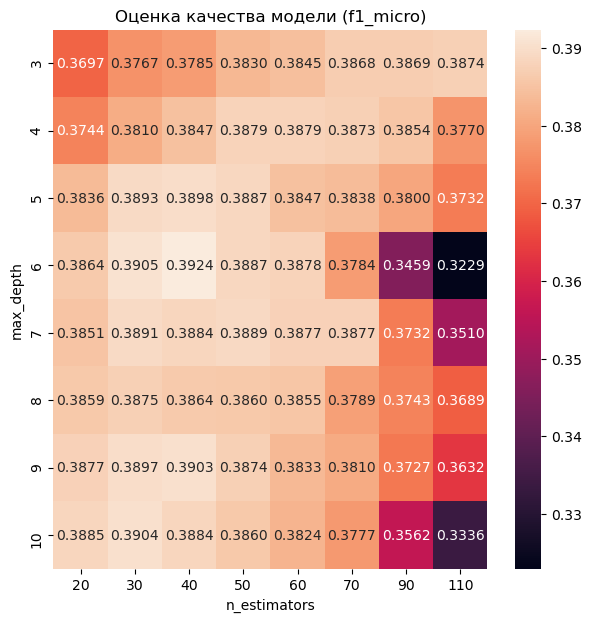

In [54]:
# визуализируем работу модели с разными параметрами
results = pd.DataFrame(grid.cv_results_)
scores = np.array(results['mean_test_score']).reshape(8,8)

plt.figure(figsize=(7, 7))

sns.heatmap(scores, 
            annot=True, 
            fmt='.4f', 
            xticklabels=param_grid['n_estimators'], 
            yticklabels=param_grid['max_depth'])
plt.title('Оценка качества модели (f1_micro)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth');

In [55]:
preds = grid.predict(X_test.drop('orderkey', axis=1))
round(f1_score(y_test, preds, average='micro'), 2)

0.39

In [56]:
pd.DataFrame(classification_report(y_test, preds, labels = grid.classes_, output_dict=True)).T

,precision,recall,f1-score,support
MYA,0.422460,0.211796,0.282143,373.000000
MYB,0.499440,0.672700,0.573265,1326.000000
MYC,0.369073,0.512725,0.429198,1336.000000
MYD,0.284553,0.241796,0.261438,579.000000
MYE,0.116279,0.053191,0.072993,188.000000
MYF,0.000000,0.000000,0.000000,44.000000
NONPACK,0.540179,0.581731,0.560185,208.000000
STRETCH,0.236111,0.149123,0.182796,114.000000
YMA,0.411215,0.090722,0.148649,485.000000
YMC,0.351767,0.347496,0.349618,659.000000


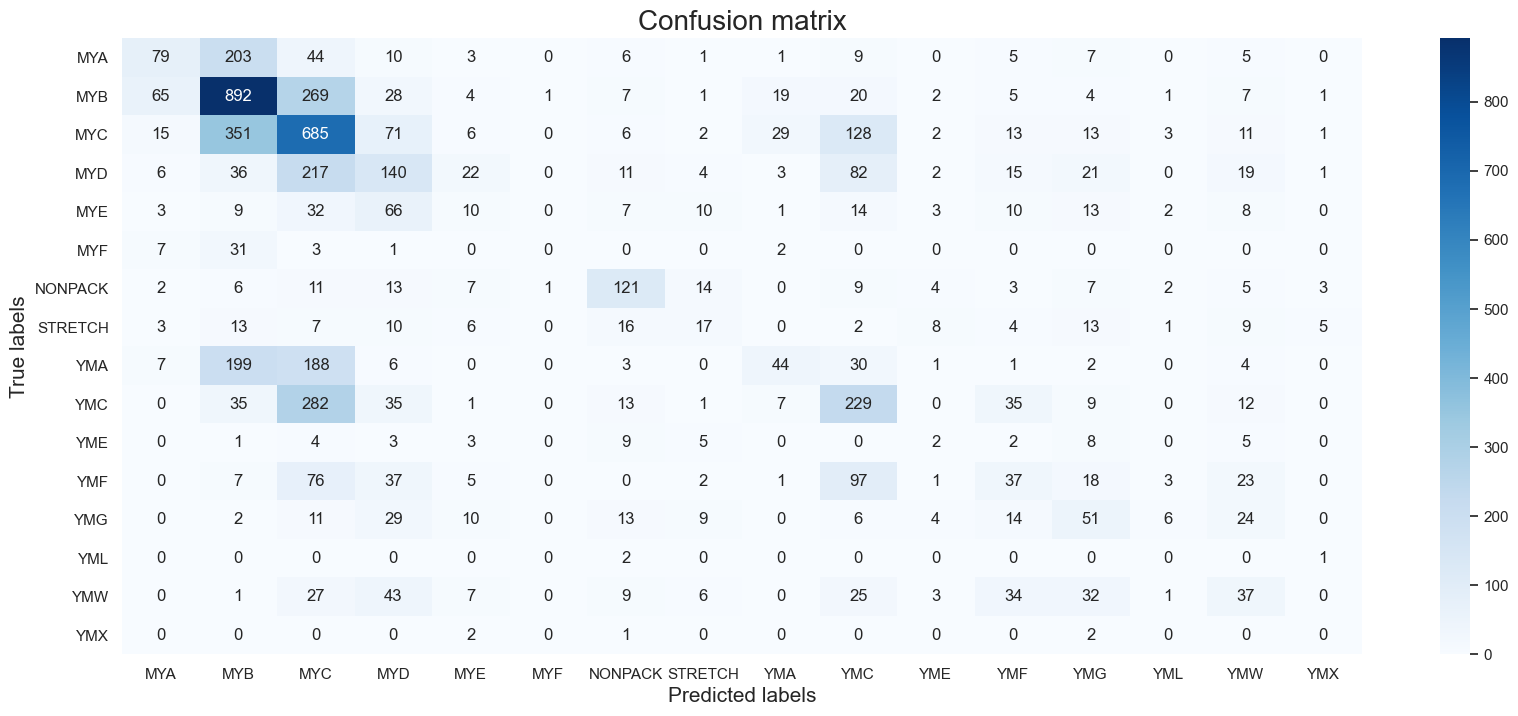

In [57]:
plt.figure(figsize=(20, 8))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix(y_test, preds),
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=grid.best_estimator_.classes_,
            yticklabels=grid.best_estimator_.classes_,
            annot_kws={"fontsize":12})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

- точность предсказаний модели составляет $0.39$, значит примерно $39$ % заказов из $19$ % исходного датасета ($16$ $970$ заказов) будут предсказаны верно;
- лучше всего, как и ожидалось, предсказываются самые многочисленные классы `MYC` и `MYB`. `NONPACK` в обучающей выборке было значительно меньше, но они также были предсказаны точнее многих остальных - примерно $60$ %;
- чтобы повысить точность предсказаний, надо увеличить наш датасет, так как сейчас для этого подхода обучающая выборка слишком маленькая и разрозненная. Лучше всего было бы получить достаточное количество данных, чтобы использовать несколько отдельных простых моделей - обучить отдельно модель на заказах из 2х товаров, отдельно на 3х и тд.

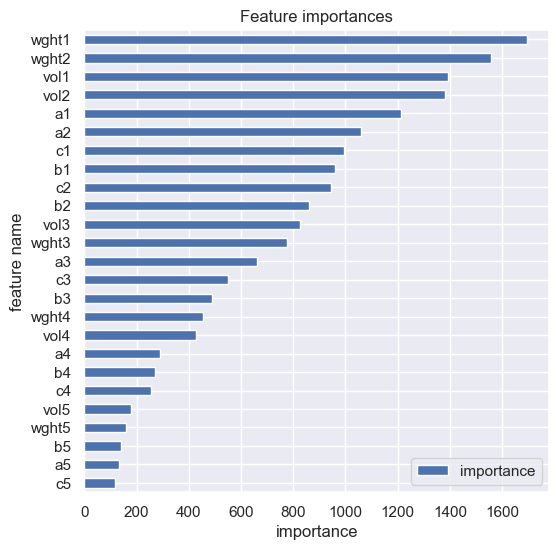

In [58]:
pd.DataFrame(data=grid.best_estimator_.feature_importances_,
             index=grid.best_estimator_.feature_name_,
             columns=['importance']).sort_values('importance').plot(kind='barh', figsize=(6,6))
plt.title('Feature importances')
plt.xlabel('importance')
plt.ylabel('feature name')
plt.show()

Сильнее всего на решение модели оказывают влияние характеристики первых двух товаров, в частности их вес и объем. Наименее важные признаки - характеристики пятого товара в заказе. Такое происходит, потому что датасет не сбалансирован по количеству товаров в заказе и заказов с двумя товарами гораздо больше, чем с пятью. Если получить достаточно количество данных и для каждого количества товаров в заказе обучить отдельную модель, точность прогноза должна увеличиться.

#### 4.2.1. Подсчет экономии и финальная точность алгоритма <a class="anchor" id="2-5_item_savings"></a>

In [59]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

f1_micro = []
predicted_costs = []
economy = []

for train_index, test_index in skf.split(X, Y):
    model_lgbm = LGBMClassifier(random_state=SEED,
                                max_depth=6,
                                n_estimators=40,
                                objective='multiclass',
                                num_classes=num_classes,
                                metric='multi_logloss')
    x_train_fold, x_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]
    model_lgbm.fit(x_train_fold.drop('orderkey', axis=1), y_train_fold)
    preds = model_lgbm.predict(x_test_fold.drop('orderkey', axis=1))
    f1_micro.append(f1_score(y_test_fold, preds, average='micro'))
    
    # посчитаем затраты на предсказанную упаковку
    x_test_fold['preds'] = preds
    predicted_fold_costs = round(x_test_fold.merge(carton[['CARTONTYPE', 'price']],
                                                   left_on='preds',
                                                   right_on='CARTONTYPE',
                                                   how='left')['price'].sum(), 2)
    predicted_costs.append(predicted_fold_costs)
    # посчитаем затраты на выбранную пользователем упаковку
    test_orders = x_test_fold['orderkey'].unique()
    costs = data[data['orderkey'].isin(test_orders)] \
                    .groupby(['orderkey', 'box_num', 'selected_cartontype_price'])['whs'] \
                    .count() \
                    .reset_index() \
                    ['selected_cartontype_price'].sum()
    economy.append(round(costs - predicted_fold_costs, 2))



print(f'List of possible f1_micro: {np.round(f1_micro, 2)}',
      f'Maximum f1_micro That can be obtained from this model is: {np.round(np.max(f1_micro), 2)}',
      f'Minimum f1_micro: {np.round(np.min(f1_micro), 2)}',
      f'Average f1_micro: {np.round(np.mean(f1_micro), 2)}',
      f'Standard Deviation is: {np.round(np.std(f1_micro), 3)}',
      f'Predicted costs: {predicted_costs}',
      f'Average predicted costs: {np.round(np.mean(predicted_costs), 2)}',
      f'Economy: {economy}',
      f'Average fold economy: {np.round(np.mean(economy), 2)}',
      sep='\n')

List of possible f1_micro: [0.38 0.39 0.39 0.39 0.39]
Maximum f1_micro That can be obtained from this model is: 0.39
Minimum f1_micro: 0.38
Average f1_micro: 0.39
Standard Deviation is: 0.004
Predicted costs: [31524.38, 30237.76, 30375.59, 30221.73, 29965.51]
Average predicted costs: 30464.99
Economy: [1571.66, 3047.76, 2722.3, 2808.65, 3189.92]
Average fold economy: 2668.06


In [60]:
print(f'Финальная экономия по датасету: {85889.33 + 2668.06 * 5 + 110541.86} руб.',
      f'Финальная экономия в %: {round((85889.33 + 2668.06 * 5 + 110541.86) / 2193243.12 * 100, 2)}',
      sep='\n')

Финальная экономия по датасету: 209771.49 руб.
Финальная экономия в %: 9.56


Предсказанные затраты на разных фолдах не сильно отличаются друг от друга. Средняя точность нашей модели на всех обучающих данных составляет также $0.39$. Количество заказов, которые мы оцениваем моделью составляет $18.99$ %, значит к общей accuracy добавляем $7.4$ % ($18.99 * 0.39$) и получаем финальную точность нашего алгоритма $76.7$ %.

Финальная экономия на упаковке составляет $209$ $771.49$ руб. или $9.56$ %.

In [61]:
# сохраним обученную на всем датасете модель для контейнера
# model = LGBMClassifier(random_state=SEED,
#                        objective='multiclass',
#                        num_classes=num_classes,
#                        metric='multi_logloss',
#                        max_depth=6,
#                        n_estimators=40)
# model.fit(X.drop('orderkey', axis=1), Y)

# with open('model.pcl', 'bw') as fid:
#     pickle.dump(model, fid)

## 5. Выводы <a class="anchor" id="conclusion"></a>

**Выявленные закономерности в данных, повлиявшие на дальнейший выбор стратегии:**
- выбранная пользователем и предложенная текущей моделью упаковка совпадает примерно в $25$ % случаев. Значит нельзя ориентироваться на рекомендованную текущей моделью упаковку. Следует взять данные о выбранной пользователями упаковке и скорректировать их;
- $65$ % датасета состоит из заказов с одним товаром в составе;
- $97$ % заказов включает в себя не более 5 товаров;
- если не считать упаковкой `NONPACK` и `STRETCH`, то в одну упаковку помещается $98.73$ % заказов;
- распределение выбранной пользователем упаковки не сбалансированно, чаще всего заказ упаковывается в маленький пакет;
- доля выбранных пользователями пакетов с учетом `NONPACK` и `STRETCH` для заказов с одноим товаром составляет примерно $63$ % из $65$ % всех заказов. Значит выбор более дешевой среди подходящих по размеру упаковок (а пакеты стоят дешевле коробок похожего размера) для заказов с одном товаром будет довольно точным и ошибки по предсказанию пакета вместо коробки будут редкими.

**Описание используемого алгоритма:**
1. проверяем карготип каждого товара в заказе, для товаров с карготипами `340` и `360` возвращаем `NONPACK` или `STRETCH` соответственно;
2. если остался один товар:
  - смотрим на исторические данные по упаковке таких товаров (в словаре sku_pack_dict собраны самые дешевые моды упаковки для sku товаров, если моды было две) и возвращаем значение, если товар найден;
  - сравниваем поэлементно размеры товара и всех коробок (минимальный с минимальным, максимальный с максимальным, медианный с медианным);
  - сравниваем диаметр окружности в раскрытом состоянии всех пакетов с диагональю меньшей грани товара-прямоугольного параллелепипеда, а также высоту пакетов и товара. К диагонали и высоте товара прибавим $10$ % и $20$ % соответственно, чтобы товар помещался в пакет без усилий;
  - неподошедшие по сравнению диагонали и диаметра пакеты будем сравнивать с товарами по линейным размерам, как коробки;
  - после сравнения выбираем самую дешевую из подходящих упаковок (функционал дизайнеров подразумеват предложение альтернатив упаковки товара, так что возвращаем топ-3 самые дешевые упаковки, при наличии).
3. если осталось 2-5 товаров:
  - проверяем для всех ли товаров указаны линейные размеры и вес;
  - если указаны для всех, делаем предсказание с помощью алгоритма градиентного бустинга и возвращаем три наиболее вероятных по мнению модели варианта упаковки.
4. если осталось более 5 товаров, не предсказываем упаковку и предлагаем упаковщику сделать выбор самостоятельно.

**Достигнутые результаты:**
- точность алгоритма приблизительно $76.7$ %, т.е. для $76.7$ % заказов алгоритм предскажет подходящую и оптимальную по цене упаковку;
- экономия на упаковке составила $209$ $771.49$ руб. или $9.56$ %. Если считать, что в нашем распоряжении были данные за один день и распределение заказов в среднем соответствует датасету, то за год экономия может составить $76.5$ млн. руб.

**Наши рекомендации и идеи по дальнейшему повышению точности алгоритма:**
- используемый подход по сравнению диаметра круга раскрытого пакета и диагонали товара-параллелепипеда это частный случай эллипса, описывающего прямоугольник. Можно усложнить расчеты, подбирая эллипс и сравнивая его длину с длиной окружности пакета. Скорее всего, с таким подходом пакеты будут предсказаны еще точнее;
- опытным путем подобрать коэффициенты увеличения длины и диагонали меньшей грани товара (вместо предложенных $10$ % и $20$ %) для его комфортной и быстрой упаковки;
- определить случаи, требующие упаковку товара только в пакет или только в коробку по карготипам и добавить соответствующие условия в алгоритм;
- увеличить датасет для заказов с 2-5 товарами в составе и обучить модели отдельно для каждого количества товаров;
- после увеличения датасета добавить новые признаки на основе характеристик товаров: площадь каждой из трех разных граней, диагонали граней, среднее линейное измерение ((a+b+c)/3), максимальное и минимальное лиейное измерение, максимальные, минимальные, средние и общие вес и объем. На датасете в $30$ тыс. заказов увеличение метрики f1_micro было незначительным - лишь на $0,01$ (и это на $20$% всех заказов), поэтому мы не стали добавлять это признаки в модель. На большом количестве данных и разных моделях под каждое количество товаров в заказе этот подход может дать результаты;
- для ml подхода определить самые важные карготипы и также добавить их в качестве новых признаков. На текущих данных ohe-векторы карготипов не дали никакого результата и только усложнили вычисления, поэтому мы не стали оставлять их в финальной версии ml-алгоритма.